### **Capstone Course**
#### Naraen Palanikumar

In [1]:
#Imports
import requests #api data retrieval
import numpy as np #array functions
from bs4 import BeautifulSoup # web scraping
import unicodedata
import pandas as pd #data manipulation
import datetime #date representation
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
import plotly.express as px
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
print("Imports Completed Succesfully!")

Imports Completed Succesfully!


In [2]:
#Auxiliary Functions
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

print("Auxiliary Functions Loaded!")

Auxiliary Functions Loaded!


In [3]:
#Data Retrieval
spacex_url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
#print(response.content)

In [4]:
#Static Data Retrieval
static_json_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
response = requests.get(static_json_url)
response.status_code

200

In [5]:
#normalize the data into frame
data = pd.json_normalize(response.json())
#data.head
print(data['static_fire_date_utc'][0])

2006-03-17T00:00:00.000Z


In [6]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [7]:
#make a dataframe with above
data = pd.DataFrame(launch_dict)
data.head

<bound method NDFrame.head of     FlightNumber        Date BoosterVersion  PayloadMass Orbit  \
0              1  2006-03-24       Falcon 1         20.0   LEO   
1              2  2007-03-21       Falcon 1          NaN   LEO   
2              4  2008-09-28       Falcon 1        165.0   LEO   
3              5  2009-07-13       Falcon 1        200.0   LEO   
4              6  2010-06-04       Falcon 9          NaN   LEO   
..           ...         ...            ...          ...   ...   
89           102  2020-09-03       Falcon 9      15600.0  VLEO   
90           103  2020-10-06       Falcon 9      15600.0  VLEO   
91           104  2020-10-18       Falcon 9      15600.0  VLEO   
92           105  2020-10-24       Falcon 9      15600.0  VLEO   
93           106  2020-11-05       Falcon 9       3681.0   MEO   

         LaunchSite    Outcome  Flights  GridFins  Reused   Legs  \
0   Kwajalein Atoll  None None        1     False   False  False   
1   Kwajalein Atoll  None None        1  

In [8]:
#Subsets Falcon 9 data and resets flightnumbers
print(data['BoosterVersion'].unique())
print(data.shape)
data_falcon9 = data[data['BoosterVersion'] != 'Falcon 1']
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
print(data_falcon9.shape)

['Falcon 1' 'Falcon 9']
(94, 17)
(90, 17)


In [9]:
#replace null values in payload mass with mean
print(data_falcon9['PayloadMass'].isnull().sum())
pm_mean = data_falcon9['PayloadMass'].mean()
data_falcon9.loc[:, 'PayloadMass'] = data_falcon9['PayloadMass'].fillna(pm_mean)
print(data_falcon9['PayloadMass'].isnull().sum())
print(data_falcon9.columns)
print(data_falcon9['LandingPad'].isnull().sum())

5
0
Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude',
       'Latitude'],
      dtype='object')
26


In [10]:
#export to csv for next part
data_falcon9.to_csv('dataset_part_1.csv', index=False)

In [11]:
#part 2 more auxiliary functions
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    

print("functions loaded successfully!")

functions loaded successfully!


In [12]:
#static scraper variables
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/91.0.4472.124 Safari/537.36"
}

response = requests.get(static_url, headers = headers)
soup = BeautifulSoup(response.text, 'html.parser')

print(soup.title)

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


In [13]:
#find and list out the actual columns names
html_tables = soup.find_all('table')
first_launch_table = html_tables[2]
th_list = first_launch_table.find_all('th')

column_names = []

for i in th_list:
    if extract_column_from_header(i) != None and len(extract_column_from_header(i)) > 0:
        column_names.append(extract_column_from_header(i))

print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


In [14]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [15]:
extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            # DONE: Append the flight_number into launch_dict with key `Flight No.`
            #print(flight_number)
            launch_dict['Flight No.'].append(flight_number)
            #print(flight_number)
            datatimelist=date_time(row[0])
            # Date value
            # DONE: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            #print(date)
            launch_dict['Date'].append(date)          
            # Time value
            # DONE: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            time = time[:5]
            #print(time)
            launch_dict['Time'].append(time)
            # Booster version
            # DONE: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            bv = bv[:7]
            tempchar = ['♺', '[', ']', 'B1', '31', '34']
            for z in tempchar:
                bv = bv.replace(z, "")
            #print(bv)
            launch_dict['Version Booster'].append(bv)
            # Launch Site
            # DONE: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            if launch_site == "Cape Canaveral":
                launch_site = "CCAFS"
            #print(launch_site)
            launch_dict['Launch site'].append(launch_site)
            # Payload
            # DONE: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            #print(payload)
            launch_dict['Payload'].append(payload)
            # Payload Mass
            # DONE: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            tempchar = ['~', ' kg', ',']
            for z in tempchar:
                payload_mass = str(payload_mass).replace(z, "")
            if payload_mass == 'C':
                payload_mass = 0
            if payload_mass == '5000–6000':
                payload_mass = 5500
            payload_mass = int(payload_mass)
            #print(payload_mass)
            launch_dict['Payload mass'].append(payload_mass)          
            # Orbit
            # DONE: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            if 'Polar' in orbit:
                orbit = 'LEO'
            #print(orbit)
            launch_dict['Orbit'].append(orbit)
            # Customer
            # DONE: Append the customer into launch_dict with key `Customer`
            customer = row[6].a
            if customer is None:
                customer = "Unknown"
            else:
                customer = customer.string
            #print(customer)
            launch_dict['Customer'].append(customer)
            # Launch outcome
            # DONE: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            #print(launch_outcome)
            launch_dict['Launch outcome'].append(launch_outcome)          
            # Booster landing
            # DONE: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            #print(booster_landing)
            launch_dict['Booster landing'].append(booster_landing)

print("Processing Complete!")


Processing Complete!


In [16]:
#export this to csv
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })
df.to_csv('spacex_web_scraped.csv', index=False)

print("csv export complete")

csv export complete


In [17]:
#part 3 data wrangling
df = pd.read_csv('dataset_part_1.csv')
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857


In [18]:
#percentage null per column
df.isnull().sum()/len(df)*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [19]:
#data types of each column
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [20]:
#counts at each site
df['LaunchSite'].value_counts()

LaunchSite
CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64

In [21]:
#counts at each orbit
df['Orbit'].value_counts()

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: count, dtype: int64

In [22]:
#landing outcomes
landing_outcomes = df['Outcome'].value_counts()
df['Outcome'].value_counts()

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

In [23]:
#makes set of bad outcomes
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [24]:
landing_class = []

for i in df['Outcome']:
    if i in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

df['Class'] = landing_class

df.to_csv("dataset_part_2_local.csv", index=False)
print("CSV exported successfully!")

CSV exported successfully!


In [25]:
#landing success rate
df["Class"].mean()

0.6666666666666666

In [26]:
#exploratory data analysis

'''
SQL Commands for Previous Section:
%sql SELECT DISTINCT Launch_Site FROM SPACEXTABLE
%sql SELECT * FROM SPACEXTABLE WHERE Launch_Site LIKE "CCA%" LIMIT 5
%sql SELECT SUM(PAYLOAD_MASS__KG_) FROM SPACEXTABLE WHERE Customer LIKE "NASA%"
%sql SELECT AVG(PAYLOAD_MASS__KG_) FROM SPACEXTABLE WHERE Booster_Version LIKE "F9 v1.1%"
%sql SELECT DISTINCT Landing_Outcome FROM SPACEXTABLE 
%sql SELECT * FROM SPACEXTABLE WHERE Landing_Outcome = "Success (ground pad)" ORDER BY Date ASC LIMIT 1
%sql SELECT DISTINCT Landing_Outcome FROM SPACEXTABLE 
%sql SELECT Booster_Version FROM SPACEXTABLE WHERE "Landing_Outcome" = 'Success (drone ship)' AND "PAYLOAD_MASS__KG_" BETWEEN 4000 AND 6000
%sql SELECT Mission_Outcome, COUNT(Mission_Outcome) AS TotalMissions FROM SPACEXTABLE GROUP BY Mission_Outcome
%sql SELECT "Booster_Version" FROM SPACEXTABLE WHERE "PAYLOAD_MASS__KG_" = (SELECT MAX("PAYLOAD_MASS__KG_") FROM SPACEXTABLE)
%sql SELECT * FROM SPACEXTABLE LIMIT 5
%sql SELECT DISTINCT Landing_Outcome FROM SPACEXTABLE
%sql SELECT substr(Date, 6,2) AS "Month", "Landing_Outcome", "Booster_Version", "Launch_Site" FROM SPACEXTABLE WHERE substr(Date,0,5)='2015' AND "Landing_Outcome" = 'Failure (drone ship)'
%sql SELECT Mission_Outcome, COUNT(Mission_Outcome) AS TotalMissions FROM SPACEXTABLE WHERE Date BETWEEN "2010-06-04" AND "2017-03-20" GROUP BY Mission_Outcome
'''

print("part 1 complete, moving onto EDA")

part 1 complete, moving onto EDA


In [27]:
#import preprocessed pt2 dataset for consistency
df = pd.read_csv('dataset_part_2.csv')
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


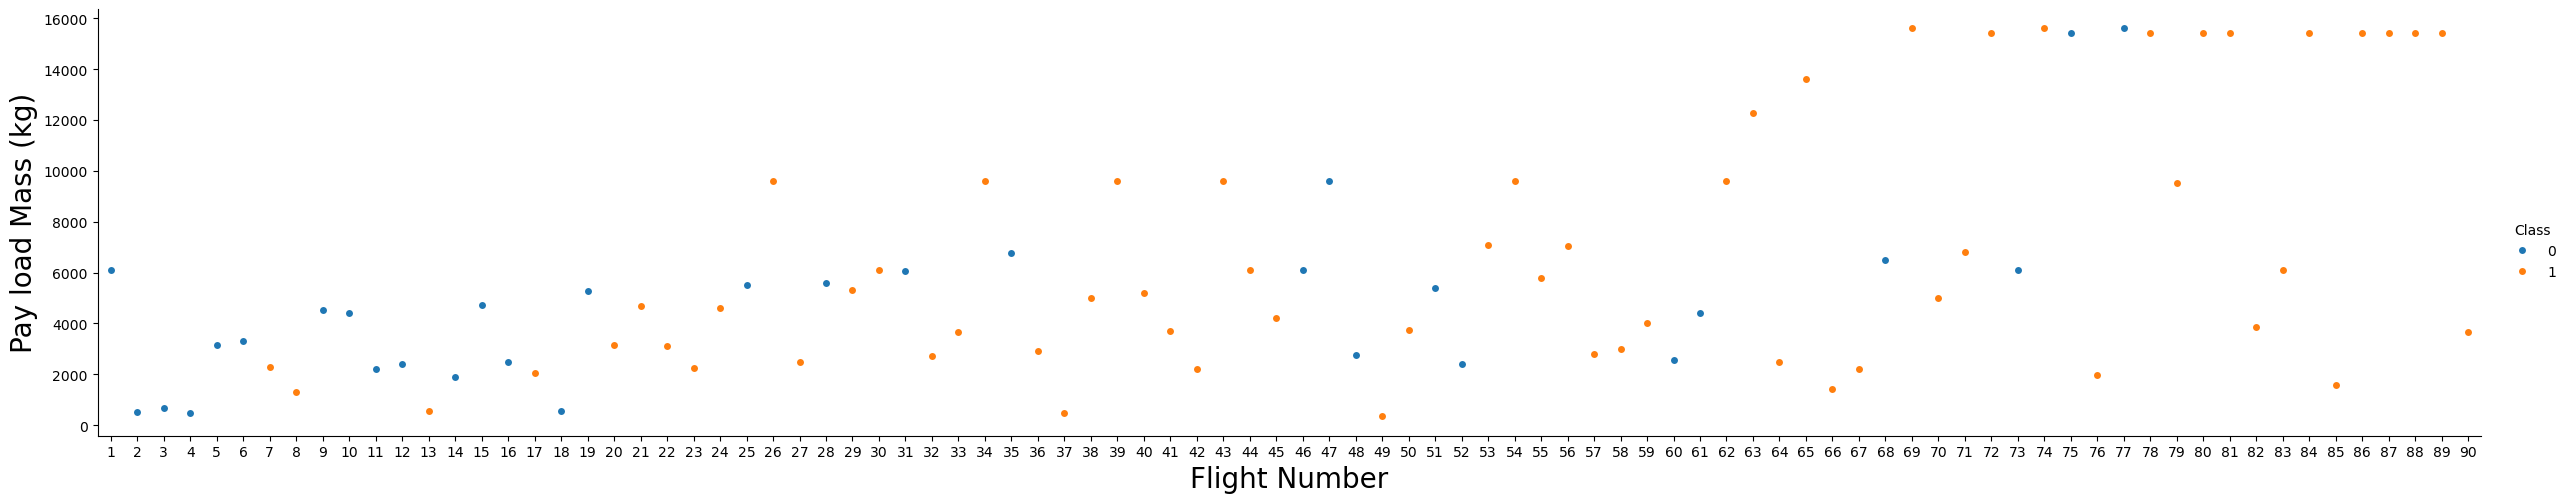

In [28]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

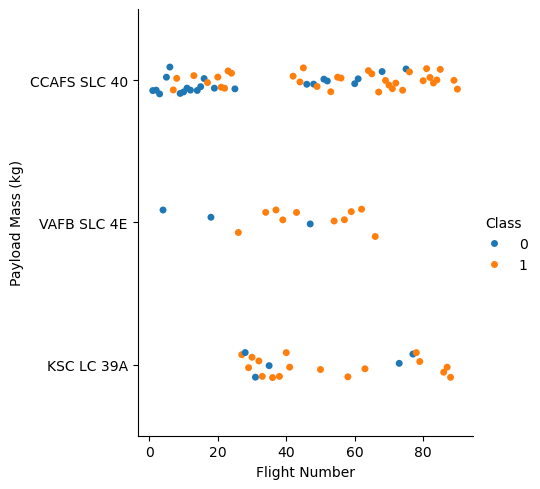

In [29]:
#flight number versus launch sit
sns.catplot(x = "FlightNumber", y = "LaunchSite", hue = "Class", data = df)
plt.xlabel("Flight Number")
plt.ylabel("Payload Mass (kg)")
plt.show()

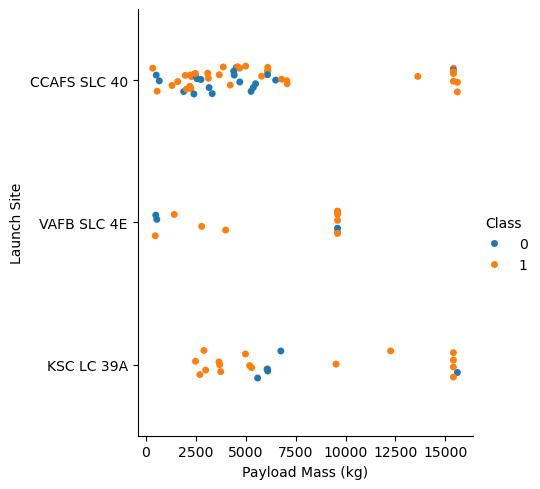

In [30]:
#payload mass vs launch site
#flight number versus launch sit
sns.catplot(x = "PayloadMass", y = "LaunchSite", hue = "Class", data = df)
plt.xlabel("Payload Mass (kg)")
plt.ylabel("Launch Site")
plt.show()

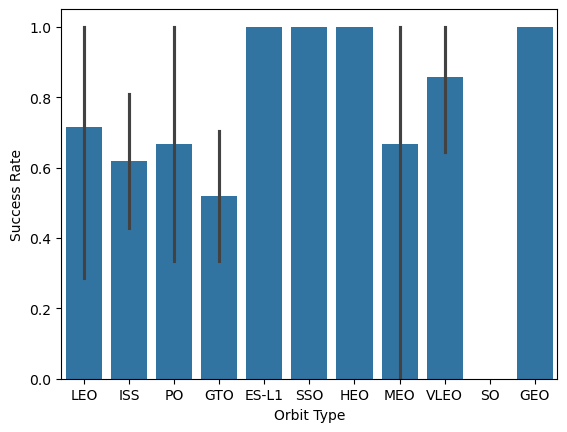

In [31]:
#success rate of each orbit type
sns.barplot(x="Orbit", y="Class", data=df)
plt.xlabel("Orbit Type")
plt.ylabel("Success Rate")
plt.show()

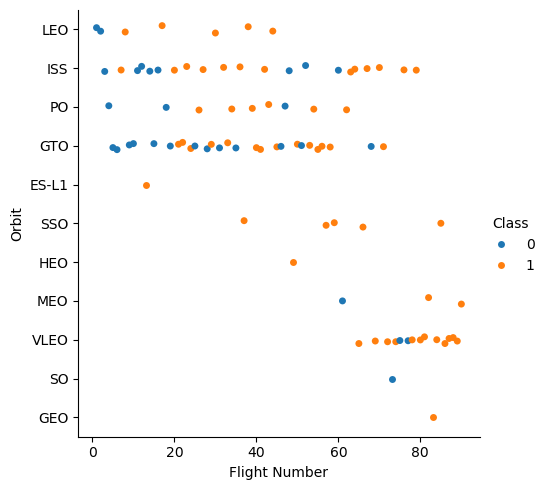

In [32]:
#flight number and orbit type
sns.catplot(x = "FlightNumber", y = "Orbit", hue = "Class", data = df)
plt.xlabel("Flight Number")
plt.ylabel("Orbit")
plt.show()

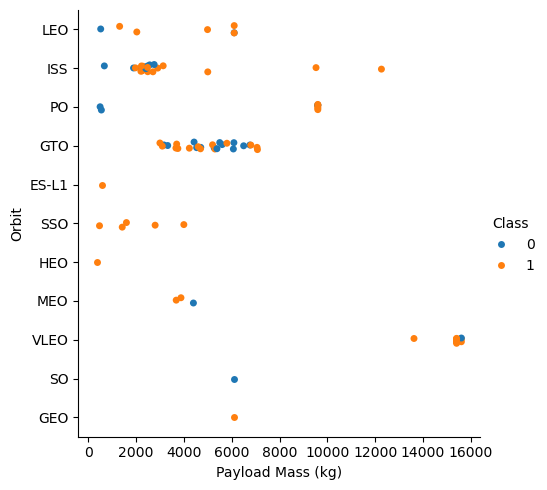

In [33]:
#payload mass and orbit type
sns.catplot(x = "PayloadMass", y = "Orbit", hue = "Class", data = df)
plt.xlabel("Payload Mass (kg)")
plt.ylabel("Orbit")
plt.show()

In [34]:
# A function to Extract years from the date 
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
Extract_year()
df['Date'] = year
df.head()


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


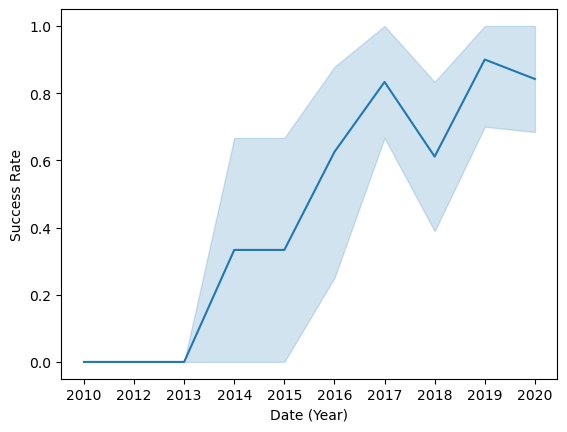

In [35]:
#success rate by date
sns.lineplot(x = "Date", y = "Class", data = df)
plt.xlabel("Date (Year)")
plt.ylabel("Success Rate")
plt.show()

In [36]:
#feature engineering
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


In [37]:
features_one_hot = pd.get_dummies(features)
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6104.959412,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,525.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,677.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,500.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,3170.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [38]:
features_one_hot = features_one_hot.astype('Float64')
features_one_hot.to_csv('dataset_part_3_local.csv', index=False)
print("eda complete!")

eda complete!


In [39]:
#mark all the launch sites on a map
spacex_df = pd.read_csv('spacex_launch_geo.csv')
spacex_df.head()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


In [40]:
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [41]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

In [42]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
for i in launch_sites_df.index:
    site_map.add_child(folium.Circle([launch_sites_df["Lat"].iloc[i], launch_sites_df["Long"].iloc[i]], radius=1000, color='#d35400', fill=True).add_child(folium.Popup(launch_sites_df["Launch Site"].iloc[i])))
    site_map.add_child(folium.map.Marker([launch_sites_df["Lat"].iloc[i], launch_sites_df["Long"].iloc[i]], icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % launch_sites_df["Launch Site"].iloc[i])))

site_map

In [43]:
spacex_df.tail(10)

,Launch Site,Lat,Long,class
46,KSC LC-39A,28.573255,-80.646895,1
47,KSC LC-39A,28.573255,-80.646895,1
48,KSC LC-39A,28.573255,-80.646895,1
49,CCAFS SLC-40,28.563197,-80.576820,1
50,CCAFS SLC-40,28.563197,-80.576820,1
51,CCAFS SLC-40,28.563197,-80.576820,0
52,CCAFS SLC-40,28.563197,-80.576820,0
53,CCAFS SLC-40,28.563197,-80.576820,0
54,CCAFS SLC-40,28.563197,-80.576820,1
55,CCAFS SLC-40,28.563197,-80.576820,0


In [44]:
marker_cluster = MarkerCluster()

marker_color = []

for i in spacex_df.index:
    if spacex_df['class'].iloc[i] == 1:
        marker_color.append('green')
    else:
        marker_color.append('red')

spacex_df['marker_color'] = marker_color

spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


In [45]:
site_map.add_child(marker_cluster)

for index, record in spacex_df.iterrows():
    marker = folium.map.Marker([record["Lat"], record["Long"]], icon = folium.Icon(color = 'white', icon_color = record["marker_color"]))
    
    marker_cluster.add_child(marker)
    
site_map

In [46]:
#distances between launch site and proximities

formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)

from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance



site_map

In [47]:
launch_lat = 28.563197
launch_lon = -80.576820
coast_lat = 28.56381
coast_lon = -80.56807
highway_lat = 28.56346
highway_lon = -80.57081
railway_lat = 28.50918 
railway_lon = -80.78507
city_lat = 28.38777
city_lon = -80.60548


dist_coast = calculate_distance(launch_lat, launch_lon, coast_lat, coast_lon)
dist_high = calculate_distance(launch_lat, launch_lon, highway_lat, highway_lon)
dist_railway = calculate_distance(launch_lat, launch_lon, railway_lat, railway_lon)
dist_city = calculate_distance(launch_lat, launch_lon, city_lat, city_lon)

distance_marker_coast = folium.Marker(
   (coast_lat, coast_lon),
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "Coast {:10.2f} KM".format(dist_coast),
       )
   )

distance_marker_high = folium.Marker(
   (highway_lat, highway_lon),
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "Highway {:10.2f} KM".format(dist_high),
       )
   )

distance_marker_rail = folium.Marker(
   (railway_lat, railway_lon),
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "Railway {:10.2f} KM".format(dist_railway),
       )
   )

distance_marker_city = folium.Marker(
   (city_lat, city_lon),
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "City {:10.2f} KM".format(dist_city),
       )
   )

site_map.add_child(distance_marker_coast)
site_map.add_child(distance_marker_high)
site_map.add_child(distance_marker_rail)
site_map.add_child(distance_marker_city)

coordinates_coast = [[coast_lat, coast_lon], [launch_lat, launch_lon]]
coordinates_highway = [[highway_lat, highway_lon], [launch_lat, launch_lon]]
coordinates_railway = [[railway_lat, railway_lon], [launch_lat, launch_lon]]
coordinates_city = [[city_lat, city_lon], [launch_lat, launch_lon]]

line_coast = folium.PolyLine(locations = coordinates_coast, weight=2, color="blue")
line_high = folium.PolyLine(locations = coordinates_highway, weight=2, color="blue")
line_railway = folium.PolyLine(locations = coordinates_railway, weight=2, color="blue")
line_city = folium.PolyLine(locations = coordinates_city, weight=2, color="blue")

site_map.add_child(line_coast)
site_map.add_child(line_high)
site_map.add_child(line_railway)
site_map.add_child(line_city)

In [49]:
#create dash application

#read data into pandas frame
spacex_df = pd.read_csv("spacex_launch_dash.csv")
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style = {'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                # The default select value is for ALL sites
                                dcc.Dropdown(id = 'site-dropdown',
                                options = [
                                    {'label': 'All Sites', 'value': 'All Sites'},
                                    {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                                    {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                                    {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                                    {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'}
                                ],
                                placeholder = 'Select a Launch Site',
                                value = 'All Sites',
                                searchable = True
                                ),
                                html.Br(),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id = 'success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # TASK 3: Add a slider to select payload range
                                dcc.RangeSlider(id = 'payload-slider',
                                                min = 0, max = 10000, step = 1000,
                                                marks = {0: '0', 10000: '10000'},
                                                value = [min_payload, max_payload]),

                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id = 'success-payload-scatter-chart')),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(Output(component_id = 'success-pie-chart', component_property = 'figure'),
                Input(component_id = 'site-dropdown', component_property = 'value'))

def get_pie_chart(launch_site):
    if launch_site == 'All Sites':
        fig = px.pie(values = spacex_df.groupby('Launch Site')['class'].mean(), 
                    names = spacex_df.groupby('Launch Site')['Launch Site'].first(),
                    title = 'Total Successful Launches by Site')
    else:
        fig = px.pie(values = spacex_df[spacex_df['Launch Site'] == str(launch_site)]['class'].value_counts(normalize = True), 
                    names = spacex_df['class'].unique(), 
                    title = 'Total Successful Launches for Site {}'.format(launch_site))
    return(fig)


# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(Output(component_id = 'success-payload-scatter-chart', component_property = 'figure'),
                [Input(component_id = 'site-dropdown', component_property = 'value'),
                Input(component_id = 'payload-slider', component_property = 'value')])

def get_payload_chart(launch_site, payload_mass):
    if launch_site == 'All Sites':
        fig = px.scatter(spacex_df[spacex_df['Payload Mass (kg)'].between(payload_mass[0], payload_mass[1])], 
                x = "Payload Mass (kg)",
                y = "class",
                color = "Booster Version Category",
                labels = {"Payload Mass (kg)": "Payload Mass (kg)", "class": "Success/Failure (1/0)"},
                hover_data = ['Launch Site'],
                title = 'Correlation Between Payload and Success for All Sites')
    else:
        df = spacex_df[spacex_df['Launch Site']==str(launch_site)]
        fig = px.scatter(df[df['Payload Mass (kg)'].between(payload_mass[0], payload_mass[1])], 
                x = "Payload Mass (kg)",
                y = "class",
                color = "Booster Version Category",
                labels = {"Payload Mass (kg)": "Payload Mass (kg)", "class": "Success/Failure (1/0)"},
                hover_data = ['Launch Site'],
                title = 'Correlation Between Payload and Success for Site {}'.format(launch_site))
    return(fig)


# Run the app
if __name__ == '__main__':
    app.run()

Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


SystemExit: 1

/home/narae/miniconda3/envs/general/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [50]:
#predictive analysis of data

def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

data = pd.read_csv("dataset_part_2.csv")
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [51]:
X = pd.read_csv("dataset_part_3.csv")
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [52]:
Y = data['Class'].to_numpy()

transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
Y_test.shape

(18,)

In [53]:
parameters ={'C':[0.01,0.1,1],
            'penalty':['l2'],
            'solver':['lbfgs']}

lr = LogisticRegression()

#create gridsearch cv and fit for parameters
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


In [54]:
Y_pred = logreg_cv.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
accuracy

0.8333333333333334

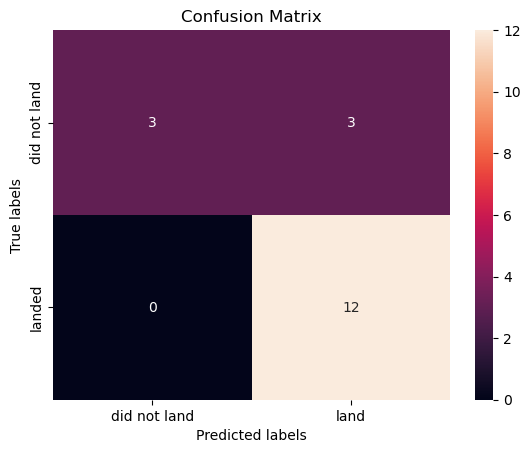

In [55]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [56]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
            'C': np.logspace(-3, 3, 5),
            'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

#svm gridsearch
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

,estimator,SVC()
,param_grid,"{'C': array([1.0000...00000000e+03]), 'gamma': array([1.0000...00000000e+03]), 'kernel': ('linear', ...)}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1.0


In [57]:
print("tuned hyperparameters (best parameters): ",svm_cv.best_params_)
print("accuracy: ",svm_cv.best_score_)

tuned hyperparameters (best parameters):  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy:  0.8482142857142856


In [58]:
accuracy = svm_cv.score(X_test, Y_test)
accuracy

0.8333333333333334

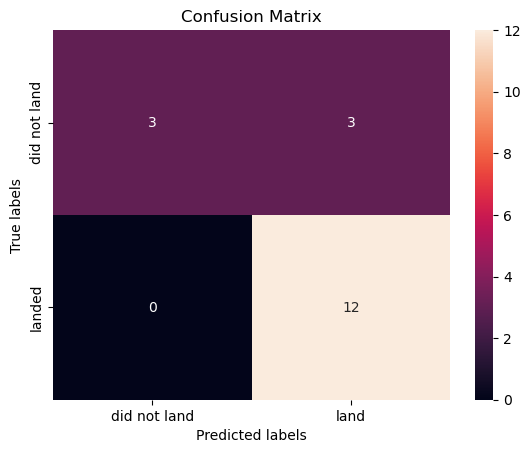

In [59]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [60]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

#tree classifier
tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv = 10)
tree_cv.fit(X_train, Y_train)

/home/narae/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning:


3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/narae/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/narae/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
  File "/home/narae/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/base.py", line 471, in _validate

,estimator,DecisionTreeClassifier()
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, ...], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [61]:
print("tuned hyperparameters (best parameters): ", tree_cv.best_params_)
print("accuracy: ", tree_cv.best_score_)

tuned hyperparameters (best parameters):  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy:  0.8910714285714285


In [62]:
best_tree = tree_cv.best_estimator_
accuracy = best_tree.score(X_test, Y_test)
accuracy

0.6666666666666666

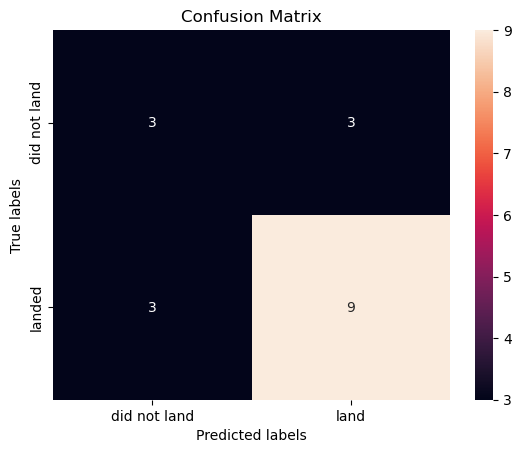

In [63]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [64]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

#gridsearch knn
knn_cv = GridSearchCV(estimator=KNN, param_grid=parameters, cv = 10)
knn_cv.fit(X_train, Y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'algorithm': ['auto', 'ball_tree', ...], 'n_neighbors': [1, 2, ...], 'p': [1, 2]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,10


In [65]:
print("tuned hyperparameters (best parameters): ", knn_cv.best_params_)
print("accuracy: ", knn_cv.best_score_)

tuned hyperparameters (best parameters):  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy:  0.8482142857142858


In [66]:
best_knn = knn_cv.best_estimator_
accuracy = best_knn.score(X_test, Y_test)
accuracy

0.8333333333333334

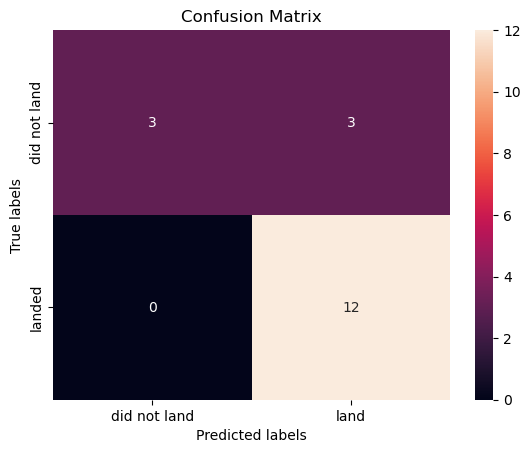

In [67]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

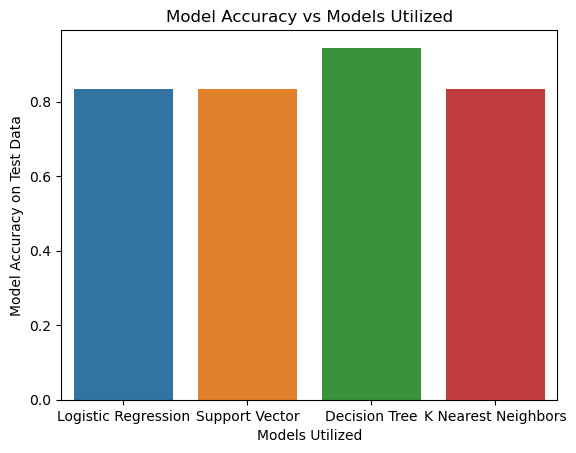

In [68]:
models = ["Logistic Regression", "Support Vector", "Decision Tree", "K Nearest Neighbors"]
scores = [0.8333333333333334, 0.8333333333333334, 0.9444444444444444, 0.8333333333333334]

model_plot = sns.barplot(x = models, y = scores, hue = models)
plt.xlabel("Models Utilized")
plt.ylabel("Model Accuracy on Test Data")
plt.title("Model Accuracy vs Models Utilized")
plt.show()